# Hidden Markov Models

This notebook goes over the calculation of $\alpha$ and $\beta$ terms, which represent the forward and backward likelihoods, or *unnormalized* posterio probabilities

In previous notebooks, we have worked with forward and backward *probabilities*, the alpha and beta terms are just the inverses:

$$ P(x_t = i | Y^t) \quad \to \quad P(Y^t | x_t = i) \propto \alpha_t(i) $$
$$ P(x_t = i | Y^{t+1, T}) \quad \to \quad P(Y^{t+1, T} | x_t = i) \propto \beta_t(i) $$

Now, in practice, we need these $\alpha$ and $\beta$ terms because the calculation of the hidden state transition probability $P(x_t=i, x_{t+1}=j | Y^T)$ turns out to be easier with these alpha and beta probabilities.

Quantitatively (much like the forward and backward probabilities) the $\alpha$ and $\beta$ probabilities are calcualted recursively. For the forward likelihood. The initial state is simply given by the column vector of the observation matrix $\boldsymbol{B}$ corresponding to the initial observation:

$$ \alpha_0 = \left[\begin{matrix} \alpha_0(0) \\ \alpha_0(1) \end{matrix}\right] = \left[\begin{matrix} B_{00} \\ B_{01} \end{matrix}\right] $$

To calculate the value of $\alpha_t$ for other $t$, we simply propogate the intial condition forward in time using (See Ref.[1])

$$ \alpha_{t+1}^{(j)} = \sum_i \alpha_t(i) A_{ji} b_j(y_{t+1})  $$

where $b_j(y_{t+1})$ is the $j$th row of column $y_{t+1}$ in the observation matrix (where here $y_{t+1}$ is the observation at time $t+1$)

Similarly, the backward likelihoods are initialized with the condition that

$$ \beta_{T-1}(i) = 1 $$

and then satisfy the similar (backwards) recurrence

$$ \beta_{t-1}(i) = \sum_j A_{ji}b_j(y_{t})\beta_t(j) $$

Using these two relationships, we can end up wth the full sequence of $\alpha$ and $\beta$ vectors.

#### References

-[1] W.H. Press, S.A. Teukolsky, & B.P. Flannery, *Numerical Recipes: The Art of Scientific Computing*, **2007**, Cambridge University Press


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from hidden import dynamics


In [2]:
a = 0.9
b = 0.8

# We introduce a slight asymmetry here just to make sure the later vectorized
# calculations are actually correct
delta = 0.01

A = np.array([[a + delta, 1 - a ], [1 - a - delta, a]])
B = np.array([[b - delta, 1 - b], [1 - b + delta, b]])

# Instantiate the simulator
hmm = dynamics.HMM(2, 2)

# Initialize the dynamics
hmm.initialize_dynamics(A, B)

# And run the dynamics for 100 steps
hmm.run_dynamics(100)


In [3]:
# Now, we can pull out the states and observation time series'
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

In [4]:
# Now we want to calculate the first few alpha terms

alpha = B[:, obs_ts[0]]
alpha

array([0.2, 0.8])

In [5]:
# Now, we can explicitly calcualte the alpha_1 term as

alpha_0 = alpha.copy()

alpha_1_0 = (alpha_0[0] * A[0, 0] * B[0, obs_ts[1]]) + (alpha_0[1] * A[0, 1] * B[0, obs_ts[1]])
alpha_1_1 = (alpha_0[0] * A[1, 0] * B[1, obs_ts[1]]) + (alpha_0[1] * A[1, 1] * B[1, obs_ts[1]])

alpha_1_0, alpha_1_1


(0.20698, 0.15498)

In [6]:
# However, we can factor out the B terms from each expression, and even vectorize the expression as
((A @ alpha_0) * B[:, obs_ts[1]])

array([0.20698, 0.15498])

In [7]:
# And therefore, we can vectorize the entire calculation as
alpha = B[:, obs_ts[0]]
alpha_tracker = [alpha]

for obs in obs_ts[1:]:
    alpha = (A @ alpha) * B[:, obs]
    alpha_tracker.append(alpha)


In [8]:
# And these first few terms match our expectations from the previous calculation
alpha_tracker[0], alpha_tracker[1]

(array([0.2, 0.8]), array([0.20698, 0.15498]))

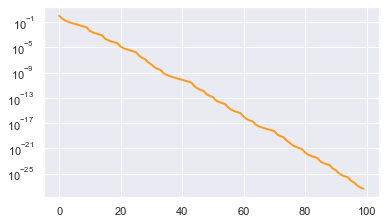

In [9]:
# To show that these are not normalized probabilities, we can look at the
# normalization over time

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
# Intuitively, this makes sense because, the likelihood of any given trajectory
# conditioned on a single current state will go down fast as that trajectory
# gets longer

ax.plot([np.sum(a) for a in alpha_tracker], linewidth=2.0, color=sns.xkcd_rgb["tangerine"], alpha=0.9)
ax.set_yscale('log')

In [10]:
# Now for the beta terms:

# Initial value is
beta = np.ones(2)
beta_T = beta.copy()
beta_T

array([1., 1.])

In [11]:
# And then we can calcualte the next term explicitly (as before)

beta_Tm1_0 = (A[1, 0] * B[1, obs_ts[-1]] * beta_T[1]) + (A[0, 0] * B[0, obs_ts[-1]] * beta_T[0])
beta_Tm1_1 = (A[1, 1] * B[1, obs_ts[-1]] * beta_T[1]) + (A[0, 1] * B[0, obs_ts[-1]] * beta_T[0])

beta_Tm1_0, beta_Tm1_1

(0.25399999999999995, 0.7400000000000001)

In [12]:
# This can also be sort-of vectorized, not quite as cleanly as the previous
# calculation, as the B terms are also contained in the summation. Howvever
# this isnt so bad, and we just have to do an element-wise multiplication of
# B[:, obs] by beta_T before the matrix multiplication by A (transpose)

A.T @ (B[:, obs_ts[-1]] * beta_T)


array([0.254, 0.74 ])

In [13]:
# So, with this we can also generate the entire sequence of beta
# values

beta = np.ones(2)
beta_tracker = [beta]
# Loop over observations from T-1 --> 0
for obs in obs_ts[-1::-1]:
    beta = A.T @ (beta * B[:, obs])
    beta_tracker.append(beta)

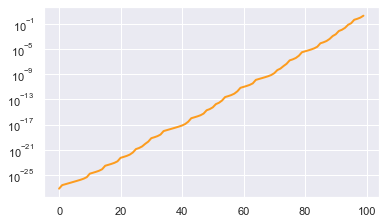

In [14]:
# As of now, the beta_tracker has its 0 element corresponding to t=T and its
# final element being t=0 so we can swap the ordering so that alpha and beta
# are in the same index reference frame

# Here beta_tracker fwd is the 'forward time' version
beta_tracker_fwd = beta_tracker[::-1][1:]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot([np.sum(b) for b in beta_tracker_fwd], linewidth=2.0, color=sns.xkcd_rgb["tangerine"], alpha=0.9)
ax.set_yscale('log')

In [15]:
len(alpha_tracker), len(beta_tracker_fwd)

(100, 100)

Text(0, 0.5, '$-\\ln \\mathcal{L}(\\theta)$')

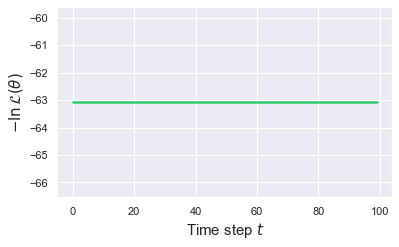

In [16]:
# Now, as a test, the likelihood (total) should be independent of t, and can be
# written as a function of alpha and beta as
# L_t = \sum_i \alpha_t(i) * beta_t(i)

likelihood = [np.sum(a * b) for a, b in zip(alpha_tracker, beta_tracker_fwd)]
log_likelihood = [np.log(np.sum(a * b)) for a, b in zip(alpha_tracker, beta_tracker_fwd)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(log_likelihood, linewidth=2.5, color=sns.xkcd_rgb["shamrock green"], alpha=0.8)
ax.set_xlabel(r"Time step $t$", fontsize=15)
ax.set_ylabel(r"$-\ln \mathcal{L}(\theta)$", fontsize=15)

In [17]:
# This is reasonable? We can also calcualte the Bayesian Smoothed probability
# supposedly, from the alpha, beta, and likelihood terms

# the probability of a given hidden state i at time t is alpha_t(i) * beta_t(i) / likelihood_t

# So, for instance, at t=10, we can get the bayesian probability as
bayes_p_0 = alpha_tracker[10][0] * beta_tracker_fwd[10][0] / likelihood[10]
bayes_p_1 = alpha_tracker[10][1] * beta_tracker_fwd[10][1] / likelihood[10]

# So, from this we can see that this is, in fact, a probability, and that
# there is a high probability of the system being in state 1
bayes_p_0, bayes_p_1, sum([bayes_p_0, bayes_p_1])

(0.06982254687677654, 0.9301774531232234, 1.0)

In [18]:
# We can then trivially (again) get this vector for the entire time series
bayes_tracker = []

for a, b, l in zip(alpha_tracker, beta_tracker_fwd, likelihood):
    bayes_tracker.append(a * b / l)

bayes_tracker[:5]

[array([0.12560235, 0.87439765]),
 array([0.15100284, 0.84899716]),
 array([0.04116453, 0.95883547]),
 array([0.01390964, 0.98609036]),
 array([0.00715674, 0.99284326])]

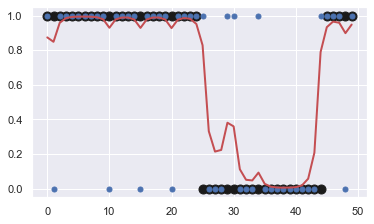

In [19]:
prob_1 = [b[1] for b in bayes_tracker]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(state_ts[:50], 'o', markersize=9, color='k', label="State")
ax.plot(obs_ts[:50], 'o', markersize=5, color='b', label="Observation")
ax.plot(prob_1[:50], linewidth=2.0, color='r')



## The Payoff: Bayesian Reparameterization

Now comes the payoff of developing the calculations of forward and backward likelihoods ($\alpha$ and $\beta$). Ultimately, we want to devise a means of actually estimating model parameters of the HMM from our observations. While in previous work we have figured out methods of optimizing the partial likelihood function, but now we wand to use some more advanced methods to optimize the true (complete data) likelihood function, using an example of an expectation-maximization algorithm called `Baum-Welch Optiiation'. This porocedure is a two-step process: first, we calculate the optimal state estimates from the forward and backward likelihoods, and then we estimate---from these probabilities---the hidden-state transition matrix elements.  

A slightly more detailed derivation in contained in Ref.[1], but the final result is that the transition matrix elements can be estimated as

$$ \hat{A}_{ij} = \frac{\sum_t \alpha_t(j) A_{ij} \beta_{t+1}(i) b_i(y_{t+1})}{\sum_t \alpha_t(i) \beta_t(i))} $$

Effectively, this formula givesus a recipe for updating our estimate of the transition matrix elements


In [66]:
# To start, reinitialize the system
hmm = dynamics.HMM(2, 2)
hmm.initialize_dynamics(A, B)
hmm.run_dynamics(100)

obs_ts, state_ts = hmm.get_obs_ts(), hmm.get_state_ts()

In [67]:
# Define an initial (wrong) estimate of the transition matrix (and observation
# matrix)
a, b = 0.9, 0.8
delta_2 = 0.05

A_est = np.array([[a + delta_2, 1 - a ], [1 - a - delta_2, a]])
B_est = np.array([[b - delta_2, 1 - b], [1 - b + delta_2, b]])


In [68]:
# Now we can calcualte the alpha and beta values as before (based on the
# current estimate of the A and B matrices)

alpha = B_est[obs_ts[0], :]
alpha_tracker = [alpha]

for obs in obs_ts[1:]:
    alpha = (A_est @ alpha) * B_est[:, obs]
    alpha_tracker.append(alpha)

beta = np.ones(2)
beta_tracker = [beta]
for obs in obs_ts[-1::-1]:
    beta = A_est.T @ (beta * B_est[:, obs])
    beta_tracker.append(beta)
beta_tracker_fwd = beta_tracker[::-1][1:]


In [75]:
# Now, from this we can calculate the updated matrix terms
A_00_new = (
    sum([a[0] * b[0] * B[0, o] for a, b, o in zip(alpha_tracker[:-1], beta_tracker_fwd[1:], obs_ts[1:])]) / 
    sum([a[0] * b[0] for a, b in zip(alpha_tracker[:-1], beta_tracker_fwd[:-1])])
)

A_01_new = (
    sum([a[1] * b[0] * B[0, o] for a, b, o in zip(alpha_tracker[:-1], beta_tracker_fwd[1:], obs_ts[1:])]) / 
    sum([a[1] * b[0] for a, b in zip(alpha_tracker[:-1], beta_tracker_fwd[:-1])])
)

A_10_new = (
    sum([a[0] * b[1] * B[1, o] for a, b, o in zip(alpha_tracker[:-1], beta_tracker_fwd[1:], obs_ts[1:])]) / 
    sum([a[0] * b[1] for a, b in zip(alpha_tracker[:-1], beta_tracker_fwd[:-1])])
)

A_11_new = (
    sum([a[1] * b[1] * B[1, o] for a, b, o in zip(alpha_tracker[:-1], beta_tracker_fwd[1:], obs_ts[1:])]) / 
    sum([a[1] * b[1] for a, b in zip(alpha_tracker[:-1], beta_tracker_fwd[:-1])])
)


A_new = np.array([[A_00_new * A[0, 0], A_01_new * A[0, 1]], [A_10_new * A[1, 0], A_11_new * A[1, 1]]])
A_new, A_est


(array([[0.93358726, 0.10358923],
        [0.08866788, 0.87081052]]),
 array([[0.95, 0.1 ],
        [0.05, 0.9 ]]))

In [74]:
# This should be normalized...
A_new.sum(axis=0)

array([1.91731907, 1.95190167])

In [35]:
# Now, we can update the elements of the hidden matrix

# Note that this is done through the formula
# numer = \sum_t alpha_t(i) * A_{ji} * beta_{t+1}(j) * B[j, obs_t+1]
# denom = \sum_t alpha_t(i) * \beta_t(i)
# A_ji_new = numer / denom

# We can calculate a sample term the the top summation

# say for i,j = 0, 1
numer_10_01 = bayes_infer.alpha_tracker[10][1] * A[0, 1] * bayes_infer.beta_tracker[11][0] * B_est[0, obs_ts[11]]
denom_10_01 = bayes_infer.alpha_tracker[10][1] * bayes_infer.beta_tracker[10][1]

numer_10_01 / denom_10_01

0.48576455118030903

In [47]:
# Now we can calculate this for each term
# First we can do it term-by-term
alpha_0 = [a[0] for a in bayes_infer.alpha_tracker]
alpha_1 = [a[1] for a in bayes_infer.alpha_tracker]
beta_0 = [b[0] for b in bayes_infer.beta_tracker]
beta_1 = [b[1] for b in bayes_infer.beta_tracker]

A_new_00 = np.sum([a * A_est[0, 0] * b * B_est[o, 0] for a, b, o in zip(alpha_0[:-1], beta_0[1:], obs_ts[1:])]) / np.sum([a * b for a, b in zip(alpha_0[:-1], beta_0[:-1])])
A_new_11 = np.sum([a * A_est[1, 1] * b * B_est[o, 1] for a, b, o in zip(alpha_1[:-1], beta_1[1:], obs_ts[1:])]) / np.sum([a * b for a, b in zip(alpha_1[:-1], beta_1[:-1])])
A_new_10 = np.sum([a * A_est[1, 0] * b * B_est[o, 1] for a, b, o in zip(alpha_0[:-1], beta_1[1:], obs_ts[1:])]) / np.sum([a * b for a, b in zip(alpha_0[:-1], beta_0[:-1])])
A_new_00 = np.sum([a * A_est[0, 1] * b * B_est[o, 0] for a, b, o in zip(alpha_1[:-1], beta_0[1:], obs_ts[1:])]) / np.sum([a * b for a, b in zip(alpha_1[:-1], beta_1[:-1])])

In [48]:
A_est, A

(array([[0.95, 0.1 ],
        [0.05, 0.9 ]]),
 array([[0.91, 0.1 ],
        [0.09, 0.9 ]]))

In [49]:
A_new_00

0.07466837505790769

In [132]:
A

array([[0.91, 0.1 ],
       [0.09, 0.9 ]])